In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


# TODO: there's some wrong in calculate trend ways, add a new method that can split data by date
class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """
    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.

        Parameters:
        - data: DataFrame containing the data.
        - method: Method for trend calculation (e.g., 'MA', 'LocalExtrema').
        - ma_days: Number of days for moving average.
        - oder_days: Number of days for order.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        """
        Calculate trend using Moving Average method.

        Parameters:
        - data: DataFrame containing the data.
        - ma_days: Number of days for moving average.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)

        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        """
        Calculate trend using Local Extrema method.

        Parameters:
        - data: DataFrame containing the data.
        - oder_days: Number of days for order.

        Returns:
        - DataFrame with trend values.
        """
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"

            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1

            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])


class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThreeMonth(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed


class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.

        Parameters:
        - feature_type: Type of feature (e.g., 'Trend', 'MACD').

        Returns:
        - Feaature object corresponding to the specified type.

        Raises:
        - ValueError: If the provided feature type is not supported.
        """
        features = {
            "Trend": IndicatorTrend,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "VMA": IndicatorVMA,
            "PctChange": IndicatorPctChange,
            "3M Treasury Yield": TreasuryYieldThreeMonth,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""
    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'drop':
            data.dropna(inplace=True)

        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'none':
            pass

        else:
            raise ValueError("Invalid strategy provided.")

        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='StandardScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        x_data = data[feature_cols]

        # Generate the one-hot encoding
        y_data = pd.get_dummies(data[target_col], prefix='Trend')

        # Check if the split index is valid
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError(
                "Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])

            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])

            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values

            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)

            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)

        return np.array(x_data_multistep), np.array(y_data_multistep), np.array(x_date), np.array(y_date)


class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """
    def __init__(self, data=None, start_date=None, end_date=None):
        # self.data = data
        self.start_date = start_date
        self.end_date = end_date
        self.trend_method = "MA"
        self.features = []
        self.processors = []

    def set_seed(self, seed_value=42):
        """Set seed for reproducibility."""
        np.random.seed(seed_value)

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        self.data = feature.compute(self.data, *args, **kwargs)

    def add_data_cleaner(self, clean_type='MissingData', strategy='drop'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(self.data)
        self.data = processor.clean(self.data, strategy=strategy)
        return issues

    def process_data(self, split_ratio=0.7, target_col="Trend", feature_cols=None, look_back=64, predict_steps=16, train_slide_steps=1, test_slide_steps=16):
        """
        Use ProcessorFactory to standardize and split the data, and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            self.data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            return X_train, y_train, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError("Invalid look_back or predict_steps provided for data preparation.")

model_data = Preprocessor()
model_data.set_seed(42)
start_date = "2001-01-01"
stop_date = "2021-01-01"
stock_symbol = "^GSPC"
model_data.data = model_data.fetch_stock_data(
    stock_symbol, start_date, stop_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
features = [
    {"type": "Trend", "method": "MA", "oder_days": 20,
        "ma_days": 20, "trend_days": 5},
    {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
    {"type": "ROC", "trend_days": 5},
    {"type": "Stochastic Oscillator", "trend_days": 5},
    {"type": "CCI", "timeperiod": 14},
    {"type": "RSI", "timeperiod": 14},
    {"type": "VMA", "timeperiod": 20},
    {"type": "PctChange"},
    {"type": "3M Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "5Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "10Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "30Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
]  # Add other features here as needed

for feature_params in features:
    feature_type = feature_params["type"]
    model_data.add_feature(feature_type, **feature_params)

C:\Users\e4903\AppData\Local\Temp\ipykernel_1976\1196187592.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_1976\1196187592.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
issues_detected = model_data.add_data_cleaner("MissingData", strategy='auto')


In [5]:
split_ratio = 0.7
target_col = "Trend"
feature_cols = None  # None means use all columns
# feature_cols = ['Trend']
look_back = 64  # number of previous days' data to consider
predict_steps = 16  # number of days to predict in the future
slide_steps = 1  # sliding window step size

X_train, y_train, X_test, y_test, train_dates, test_dates = model_data.process_data(split_ratio=0.7, target_col="Trend", feature_cols=feature_cols, look_back=look_back,
                        predict_steps=predict_steps, train_slide_steps=1, test_slide_steps=predict_steps)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3430, 64, 19), (3430, 16, 2), (90, 64, 19), (90, 16, 2))

In [6]:
import numpy as np
import tensorflow as tf
import random

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [58]:
import numpy as np
# import tensorflow as tf
import random
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation
# from keras.optimizers import Adam
# from keras import regularizers
# from keras import metrics
# from keras.callbacks import EarlyStopping
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tqdm import tqdm
import datetime
# from tensorflow.keras.models import load_model
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset


class ModelBase:
    def __init__(self, model=None, params=None, input_shape=None):
        self.model = model
        self.params = params
        self.input_shape = input_shape

    # def create(self):
    #     raise NotImplementedError("Subclasses should implement this method.")

    # def train(self):
    #     raise NotImplementedError("Subclasses should implement this method.")

    # def infer(self):
    #     raise NotImplementedError("Subclasses should implement this method.")

    # def online_train(self):
    #     raise NotImplementedError("Subclasses should implement this method.")


# class NeuralNetworkModelBase(ModelBase):
#     def train(self, X_train, y_train):
#         # Define callbacks, such as EarlyStopping
#         early_stopping = EarlyStopping(
#             monitor='loss',
#             patience=self.params.get('patience', 5),
#             restore_best_weights=True
#         )
#         # Train the model
#         history = self.model.fit(
#             X_train, y_train,
#             epochs=self.params.get('epochs', 10),
#             batch_size=self.params.get('batch_size', 32),
#             callbacks=[early_stopping],
#             verbose=2
#         )
#         return history

#     def infer(self, X_test):
#         # Predict the next instance (optional, depending on your requirements)
#         y_pred = self.model.predict(X_test)
#         return y_pred


class NeuralNetworkModelBase(ModelBase, nn.Module):
    def __init__(self):
        super(ModelBase, self).__init__()

    def train_model(self, X_train, y_train, params):
        self.train()  # Sets the module in training mode
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=params.get('batch_size', 32))

        optimizer = Adam(self.parameters(), lr=params.get('learning_rate', 0.001))
        criterion = nn.BCELoss()

        total_loss = 0
        total_accuracy = 0

        for epoch in range(params.get('epochs', 10)):
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                y_pred = self(X_batch, params)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                # Convert predictions and actual labels to numpy arrays
                predicted = torch.round(y_pred).detach().numpy()
                actual = y_batch.detach().numpy()

                # Flatten arrays if they are not 1D
                predicted = predicted.flatten()
                actual = actual.flatten()

                # Add check for binary values in actual and predicted
                if not np.array_equal(actual, actual.astype(bool)) or not np.array_equal(predicted, predicted.astype(bool)):
                    raise ValueError("Non-binary values encountered in actual or predicted labels")

                total_accuracy += accuracy_score(actual, predicted)

        # Average the loss and accuracy over all epochs
        avg_loss = total_loss / (len(dataloader) * params.get('epochs', 10))
        avg_accuracy = total_accuracy / (len(dataloader) * params.get('epochs', 10))

        return {"loss": avg_loss, "binary_accuracy": avg_accuracy}

    def infer(self, X_test):
        self.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            y_pred = self(X_test_tensor, self.params)
        return y_pred.numpy()
    
    def online_train(self, X_train, y_train, single_X_test, single_y_test, data_update_mode='newest'):
        # Update the training dataset with the new instance
        if data_update_mode == 'append':
            online_X_train = np.append(X_train, single_X_test, axis=0)
            online_y_train = np.append(y_train, single_y_test, axis=0)
        elif data_update_mode == 'replace':
            online_X_train = np.append(X_train[1:], single_X_test, axis=0)
            online_y_train = np.append(y_train[1:], single_y_test, axis=0)
        elif data_update_mode == 'newest':
            online_X_train = single_X_test
            online_y_train = single_y_test
        else:
            raise ValueError(f"Invalid data update mode: {data_update_mode}")

        # Convert to PyTorch tensors
        online_X_train_tensor = torch.tensor(online_X_train, dtype=torch.float32)
        online_y_train_tensor = torch.tensor(online_y_train, dtype=torch.float32)
        online_dataset = TensorDataset(online_X_train_tensor, online_y_train_tensor)
        online_dataloader = DataLoader(online_dataset, batch_size=self.params.get('batch_size', 32))

        # Retrain the model on this updated dataset
        self.train()  # Ensure the model is in training mode
        optimizer = Adam(self.parameters(), lr=self.params.get('learning_rate', 0.001))
        criterion = nn.BCELoss()

        # Initialize variables to track metrics
        total_loss = 0
        total_accuracy = 0

        # Online training loop
        for X_batch, y_batch in online_dataloader:
            optimizer.zero_grad()
            y_pred = self(X_batch, self.params)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Detach tensors from the computation graph before converting to numpy
            predicted = torch.round(y_pred).detach().numpy()
            actual = y_batch.detach().numpy()

            # Calculate binary accuracy
            total_accuracy += accuracy_score(actual, predicted)

        # Average the loss and accuracy over all batches
        avg_loss = total_loss / len(online_dataloader)
        avg_accuracy = total_accuracy / len(online_dataloader)

        return {"loss": avg_loss, "binary_accuracy": avg_accuracy}


class Modelseq2seq(NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(Modelseq2seq, self).__init__()
        self.params = params
        sequence_length, num_features = input_shape

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=params['conv_1_filter'], kernel_size=params['conv_1_kernel'], padding='same')
        self.bn1 = nn.BatchNorm1d(params['conv_1_filter'])
        self.dropout1 = nn.Dropout(params['dropout_1'])
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=params['conv_1_filter'], out_channels=params['conv_2_filter'], kernel_size=params['conv_2_kernel'])
        self.bn2 = nn.BatchNorm1d(params['conv_2_filter'])
        self.dropout2 = nn.Dropout(params['dropout_2'])
        self.pool2 = nn.MaxPool1d(2)

        # Calculate the size of the output from the last convolutional layer
        conv_output_size = self._get_conv_output(input_shape)

        # LSTM layers
        self.lstm1 = nn.LSTM(conv_output_size, params['lstm_1_units'], batch_first=True)
        self.repeat = nn.Linear(params['lstm_1_units'], params['predict_steps'] * params['lstm_1_units'])
        self.lstm2 = nn.LSTM(params['lstm_1_units'], params['lstm_2_units'], batch_first=True)
        self.output_layer = nn.Sequential(
            nn.Linear(params['lstm_2_units'], 2),
            nn.Sigmoid())

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.rand(batch_size, *shape)
        input = input.permute(0, 2, 1)  # Reshape to (batch_size, num_features, sequence_length)
        output = self.pool1(self.conv1(input))
        output = self.pool2(self.conv2(output))
        return output.numel() // batch_size  # Total number of features

    def forward(self, x, params):
        # Forward pass through CNN
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, num_features, sequence_length)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        # Reshape for LSTM input
        x = x.flatten(start_dim=1)

        # Forward pass through LSTM
        x, _ = self.lstm1(x.unsqueeze(1))
        x = self.repeat(x).view(x.size(0), -1, params['lstm_1_units'])
        x, _ = self.lstm2(x)
        x = self.output_layer(x)

        return x

# class Modelseq2seq(NeuralNetworkModelBase):
#     def create(self):
#         model = Sequential()
#         print(self.params)
#         # Encoder
#         model.add(Conv1D(filters=self.params['conv_1_filter'],
#                          kernel_size=self.params['conv_1_kernel'],
#                          activation=None,
#                          padding='same',
#                          kernel_regularizer=regularizers.l2(
#                              self.params['conv_1_l2']),
#                          input_shape=self.input_shape))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(self.params['dropout_1']))
#         model.add(MaxPooling1D(pool_size=2))

#         model.add(Conv1D(filters=self.params['conv_2_filter'],
#                          kernel_size=self.params['conv_2_kernel'],
#                          activation=None))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(self.params['dropout_2']))
#         model.add(MaxPooling1D(pool_size=2))

#         model.add(LSTM(units=self.params['lstm_1_units'],
#                        activation=None,
#                        return_sequences=False,
#                        kernel_regularizer=regularizers.l2(self.params['lstm_1_l2'])))
#         model.add(BatchNormalization())
#         model.add(Activation('tanh'))
#         model.add(Dropout(self.params['dropout_3']))

#         # Set the desired output sequence length using RepeatVector
#         model.add(RepeatVector(self.params['predict_steps']))

#         # Decoder
#         model.add(LSTM(units=self.params['lstm_2_units'],
#                        activation=None,
#                        return_sequences=True))
#         model.add(BatchNormalization())
#         model.add(Activation('tanh'))
#         model.add(Dropout(self.params['dropout_4']))
#         model.add(TimeDistributed(Dense(2, activation='softmax')))

#         optimizer = Adam(learning_rate=self.params['learning_rate'])
#         model.compile(optimizer=optimizer,
#                       loss='binary_crossentropy',
#                       metrics=[metrics.BinaryAccuracy()])
#         model.summary()
#         self.model = model


# class ModelCNN(NeuralNetworkModelBase):
#     pass

# class ModelFFT(ModelBase):
#     pass

# class ModelMA(ModelBase):
#     pass


# class ModelFactory:
#     @staticmethod
#     def create_model_instance(model_type, params=None, input_shape=None, keras_model=None, *args, **kwargs):
#         models = {
#             "seq2seq": Modelseq2seq,
#             # "cnn": ModelCNN,
#             # "fft": ModelFFT,
#             # "ma": ModelMA,
#             # Add other models here as needed
#         }
#         model_instance = models.get(model_type)
#         if model_instance is None:
#             raise ValueError(f"Invalid model type: {model_type}")
#         if keras_model:
#             instance = model_instance(keras_model)
#         else:
#             instance = model_instance(None, params, input_shape)
#         return instance

class ModelFactory:
    @staticmethod
    def create_model_instance(model_type, params=None, input_shape=None):
        models = {
            "seq2seq": Modelseq2seq,
            # Add other model types here
        }
        if model_type in models:
            return models[model_type](params, input_shape)
        else:
            raise ValueError(f"Invalid model type: {model_type}")


# class Model:
#     def create_model(self, model_type, params=None, input_shape=None):
#         # Create the model instance
#         model_instance = ModelFactory.create_model_instance(
#             model_type, params, input_shape)
#         # Ensure the model is created (initialized)
#         model_instance.create()
#         return model_instance

#     def train_model(self, model, X_train, y_train):
#         # Train the model
#         return model.train(X_train, y_train)

#     def infer_model(self, model, X_test):
#         # Perform inference using the model
#         return model.infer(X_test)

#     def online_train_model(self, model, X_train, y_train, single_X_test, single_y_test):
#         # Perform online training on the model
#         return model.online_train(X_train, y_train, single_X_test, single_y_test)

#     def evaluate_model(self, model, y_preds, y_test):
#         # Evaluate the model
#         return model.evaluate(y_preds, y_test)

#     def save_model(self, model, base_filename='model'):
#         # Create a timestamp or unique identifier
#         timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#         filename = f'{base_filename}_{timestamp}.h5'

#         # Save the model
#         model.model.save(filename)
#         print(f'Model saved as {filename}')

#     def load_model(self, model_type, model_path):
#         # Load the pre-trained Keras model
#         loaded_keras_model = load_model(model_path)
#         print(f'Model loaded from {model_path}')

#         # Wrap the Keras model in the appropriate custom model class
#         model_instance = ModelFactory.create_model_instance(
#             model_type, keras_model=loaded_keras_model)
#         return model_instance


class Model:
    def create_model(self, model_type, params=None, input_shape=None):
        model_instance = ModelFactory.create_model_instance(model_type, params, input_shape)
        return model_instance

    def train_model(self, model, X_train, y_train, params):
        return model.train_model(X_train, y_train, params)  # Use train_model method

    def infer_model(self, model, X_test):
        return model.infer(X_test)

    def save_model(self, model, file_path):
        torch.save(model.state_dict(), file_path)

    def load_model(self, model, file_path):
        model.load_state_dict(torch.load(file_path))
        model.eval()
        return model
    
    def online_train_model(self, model, X_train, y_train, single_X_test, single_y_test):
        # Perform online training on the model
        return model.online_train(X_train, y_train, single_X_test, single_y_test)

    def run(self, model_type, look_back, params, X_train, y_train, X_test, y_test, pre_trained_model_path=None):
        if pre_trained_model_path:
            # Load the pre-trained model
            model = self.load_model(model_type, pre_trained_model_path)
            history = None
        else:
            # Create a new model if no pre-trained model is provided
            input_shape = (look_back, X_train.shape[-1])
            model = self.create_model(model_type, params, input_shape)
            # Train the new model
            history = self.train_model(model, X_train, y_train, params)
            # Save the initial trained model
            self.save_model(model, 'initial_model')

        online_training_losses = []
        online_training_acc = []
        y_preds = []
        for i in tqdm(range(len(X_test))):
            # Predict the next instance
            y_pred = self.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])

            # Perform online training
            online_history = self.online_train_model(
                model, X_train, y_train, X_test[i:i+1], y_test[i:i+1])
            online_training_losses.append(online_history['loss'])
            online_training_acc.append(
                online_history['binary_accuracy'])
        y_preds = np.array(y_preds)

        # Save the model after each online training iteration
        self.save_model(model, 'online_model')

        return model, history, y_preds, online_training_losses, online_training_acc


In [59]:
params = {
    'conv_1_filter': 32,
    'conv_1_kernel': 4,
    'conv_1_l2': 0.00016475815766673417,
    'dropout_1': 0.2,
    'conv_2_filter': 96,
    'conv_2_kernel': 2,
    'dropout_2': 0.2,
    'lstm_1_units': 128,
    'lstm_1_l2': 0.0002788818914602332,
    'dropout_3': 0.2,
    'lstm_2_units': 64,
    'dropout_4': 0.1,
    'learning_rate': 0.001,
    'predict_steps': predict_steps
}
model_type = 'seq2seq'
model_wrapper = Model()
# TODO: add a method to use more parameters
model, history, y_preds, online_training_losses, online_training_acc = model_wrapper.run(model_type, look_back, params, X_train, y_train, X_test, y_test)


  0%|          | 0/90 [00:00<?, ?it/s]


ValueError: unknown is not supported

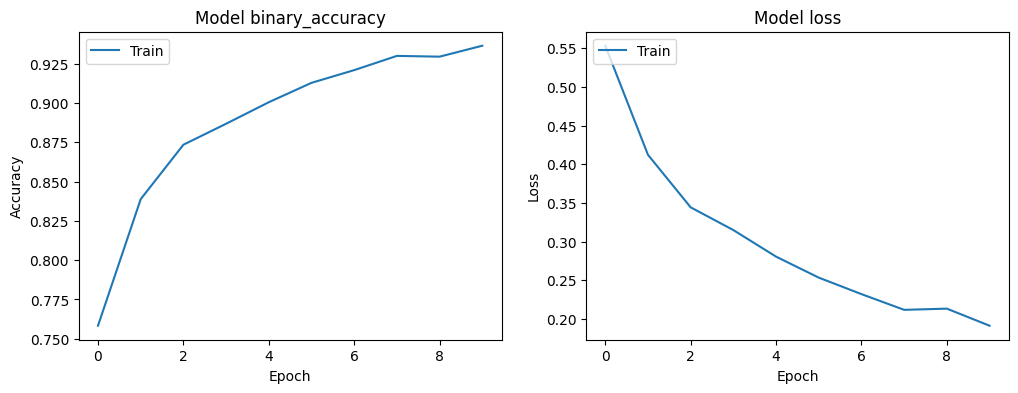

In [ ]:
# Function to plot training curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    # plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model binary_accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Plot the training curves
plot_training_curves(history)

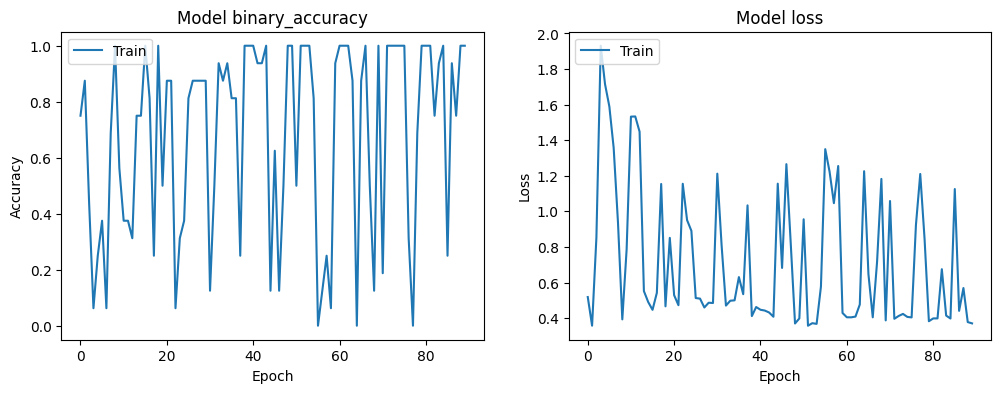

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_acc)
# plt.plot(val_acc)
plt.title('Model binary_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_losses)
# plt.plot(val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Output the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Precision: 0.6525504327334595
Recall: 0.6326058201058201
Accuracy: 0.7152777777777778
F1 Score: 0.6389776904845184


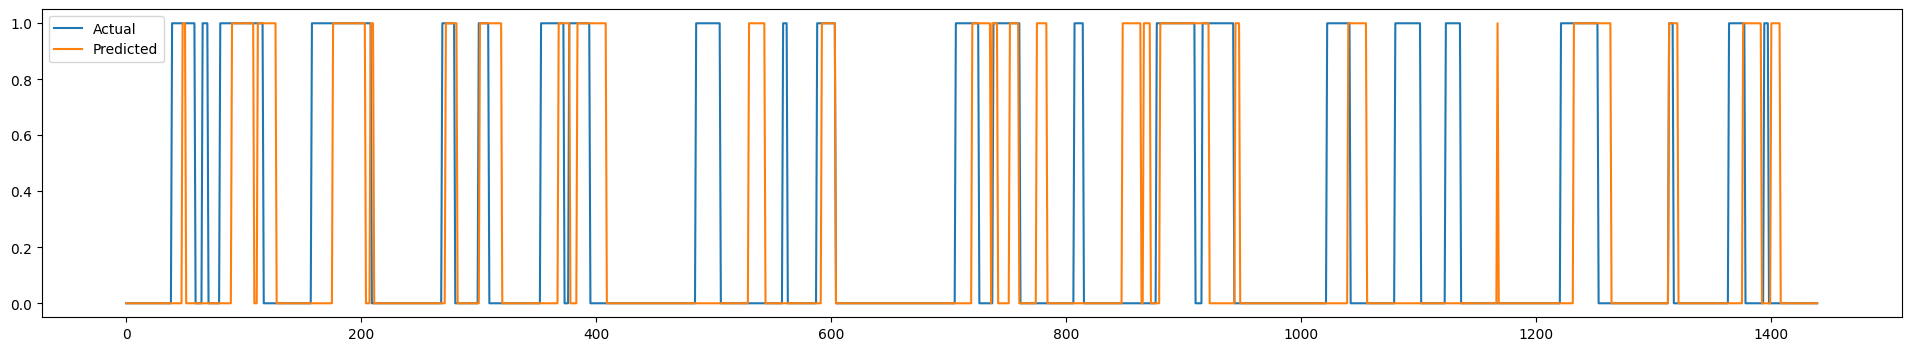

In [ ]:
y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)
plt.figure(figsize=(24, 4))
plt.plot(y_test_flat, label='Actual')
plt.plot(y_preds_flat, label='Predicted')
plt.legend()
plt.show()